## Runs DE on different clusters. Also runs DE within each cluster for each condition.
Does this over each donor and combined

In [1]:
# Input info
se_f = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/annotation_clones/SE.rds"
clone_changes_f = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clones_change/filt_fisher__shuffle_False__padj_True__pthresh_0.01_minC_1__bothMinC__0/preproc/clone_change.csv"

outdir = "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clones_change/filt_fisher__shuffle_False__padj_True__pthresh_0.01_minC_1__bothMinC__0/de/btwnChange_inClust/minPct_0.01__logfc0.1_pthresh_0.01"
sample_names = "preB,postB"

# Parallel processing
cores = 4
# R utils script
utils_script <- "/data/Mito_Trace/R_scripts/seurat_utils.R"

top_de = 3
logfcthresh=0.1
minPct = 0.01
p_thresh=0.01

In [2]:
source(utils_script)
source("/data/Mito_Trace/R_scripts/plot_de_over_all.R")
dir.create(outdir)
donor.outdir <- file.path(outdir, "sepDonors")
dir.create(donor.outdir)

all.donor.outdir <- file.path(outdir, "allDonors")
dir.create(all.donor.outdir)

Attaching SeuratObject


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Warning message in dir.create(outdir):
“'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clones_change/filt_fisher__shuffle_False__padj_True__pthresh_0.01_minC_1__bothMinC__0/de/btwnChange_inClust/minPct_0.01__logfc0.1_pthresh_0.01' already exists”
Warning message in dir.create(donor.outdir):
“'/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clones_change/filt_fisher__shuffle_False__padj_True__pthresh_0.

In [3]:
sample_names <- unlist(strsplit(sample_names, ",")[[1]])
sample_names

[1] "preB"  "postB"

In [4]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library("RColorBrewer")
library(dplyr)
library(future)
plan()

plan("multiprocess", workers = cores)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
options(future.globals.maxSize = 8000 * 1024^2)

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:dplyr’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:dplyr’:

    first, rename


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package:

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

Warning message:
"Strategy 'multiprocess' is deprecated in future (>= 1.20.0). Instead, explicitly specify either 'multisession' or 'multicore'. In the current R session, 'multiprocess' equals 'multicore'."


In [5]:
se <- readRDS(se_f)#file.path(indir, paste0("allSamples.integrated.rds")))
se

An object of class Seurat 
97805 features across 22239 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap

# Load clone_changes

In [6]:
clone_changes_f

[1] "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clones_change/filt_fisher__shuffle_False__padj_True__pthresh_0.01_minC_1__bothMinC__0/preproc/clone_change.csv"

In [7]:
clone_changes <- read.csv(clone_changes_f)
row.names(clone_changes) <-clone_changes$name

In [8]:
clone_changes[c("name","change")]

,name,change
,<chr>,<chr>
0_5,0_5,regress
0_25,0_25,regress
0_8,0_8,expand
0_12,0_12,regress
0_17,0_17,expand
1_39,1_39,regress
1_1,1_1,regress
0_11,0_11,regress
0_24,0_24,regress


## Subset clones

### Add change col metadata for each clone
a) subset se by clone names
b) need to map each cell based on the clone value, create a dataframe. should be same number rows as se

In [9]:
se.filt <- subset(se , subset = name %in% clone_changes$name)
se.filt = subset(se.filt , subset = (name != "None"))

In [10]:
meta <- se.filt[[]]
meta$change <- NA
for (cell in row.names(meta)){
    curr <- clone_changes[as.character(meta[cell, "name"]),"change"]
    if(is.na(curr)){
        break
    }
    meta[cell, "change"] = curr
}

se.filt <- AddMetaData(se.filt, meta[["change"]], col.name="change")


In [11]:
clust.ids <- levels(se.filt$seurat_clusters)
don.ids <- levels(se.filt$donor)


Idents(se.filt) <- as.factor(apply(se.filt[[]][ , c("donor", "seurat_clusters", "change") ] , 1 , paste , collapse = "_" ))

# se.filt$change.stim <- paste(se.filt$change, se.filt$orig.ident, sep = "_")
# Idents(se.filt) <- "change"


#curr.ids <- levels(as.factor(apply(se[[]][ , c("seurat_clusters", "donor") ] , 1 , paste , collapse = "_" )))
#se$curr.id = Idents(se)

## a) For each donor, de for expanded vs regressed vs no change

[1] "donor 0"
[1] "clust"
[1] "0"
[1] "pairs"
[1] "expand"  "regress"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 41 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 7231    6
[1] "pairs"
[1] "expand"    "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 74 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 6221    6
[1] "pairs"
[1] "regress"   "no_change"
[1] 

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "expand"    "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 186 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 4890    6
[1] "pairs"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 161 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 4928    6
[1] "clust"
[1] "2"
[1] "pairs"
[1] "regress"   "no_change"
[1] "se filt

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 869 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
INPP5A   2.361995e-08  0.2663979 0.561 0.344 0.0004623605 6.259840e-06
THAP4    3.628893e-08  0.1479717 0.259 0.108 0.0007103558 6.259840e-06
KIAA1462 9.207041e-08  0.1342350 0.384 0.193 0.0018022782 8.604880e-06
DYNLL1   1.020270e-07  0.1501991 0.333 0.163 0.0019971791 8.604880e-06
RPRD2    1.247084e-07  0.1284559 0.389 0.198 0.0024411671 8.604880e-06
C17orf63 2.646266e-07  0.1203588 0.370 0.191 0.0051800652 1.440308e-05
[1] "dim response"
[1] 345   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1428 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 147   6
[1] "clust"
[1] "3"
[1] "pairs"
[1] "no_change" "regress"  
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 51 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 8405    6
[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt b

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 921 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 331   6
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 569 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                   p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
VWF         4.943624e-07  0.1470653 0.179 0.047 0.009677144 0.0002020191
REV1        5.994632e-07  0.1920213 0.401 0.192 0.011734492 0.0002020191
ZNF627     

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "clust"
[1] "5"
[1] "pairs"
[1] "no_change" "regress"  
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 37 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 9029    6
[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 44 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 7843    6
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt befor

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 930 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                    p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
IL4I1        1.129232e-05  0.1122247 0.283 0.153 0.2210472  0.001744323
MRPL24       1.228397e-05  0.1523076 0.242 0.128 0.2404586  0.001744323
MTA3         1.906596e-05  0.1996656 0.451 0.300 0.3732161  0.001804910
NUP62        4.576536e-05  0.1020014 0.219 0.114 0.8958569  0.002949067
CTC-326K19.6 5.192020e-05  0.1090322 0.239 0.130 1.0000000  0.002949067
LRRC8A       6.360078e-05  0.1220255 0.306 0.186 1.0000000  0.003010437
[1] "dim response"
[1] 284   6


The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "expand"    "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 894 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 468   6
[1] "clust"
[1] "7"
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 302 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 1668    6
[1] "pairs"
[1] "regress"   "no_change"
[1] "se filt befor

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 718 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 682   6
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 411 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                     p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
THEMIS2       1.094778e-07  0.1398092 0.163 0.017 0.002143028 0.0001462624
DIS3          3.085174e-07  0.2405927 0.410 0.167 0.006039228 0.0002060896
ATP8B

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "clust"
[1] "10"
[1] "pairs"
[1] "no_change" "regress"  
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 44 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 8307    6
[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 43 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 8527    6
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt befo

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 559 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
HES1    9.002044e-09  0.1405311 0.275 0.084 0.000176215 2.448556e-06
TNS4    5.092000e-07  0.1577808 0.414 0.196 0.009967590 6.925120e-05
TIGD7   2.554655e-06  0.1026693 0.223 0.077 0.050007378 2.316221e-04
ZNF75A  4.885837e-06  0.1003395 0.223 0.080 0.095640250 3.322369e-04
NPHP3   6.338756e-06  0.1337206 0.399 0.206 0.124081157 3.448283e-04
ADPRHL2 1.040054e-05  0.1004914 0.176 0.056 0.203590659 4.714914e-04
[1] "dim response"
[1] 272   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1629 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
HES1     6.849542e-06  0.1032665 0.196 0.084 0.1340798 0.0003561762
NPHP3    4.364535e-05  0.1131417 0.340 0.206 0.8543578 0.0011337910
ARHGEF12 6.541102e-05 -0.1193995 0.109 0.189 1.0000000 0.0011337910
INTS6L   4.521168e-04  0.1165960 0.483 0.364 1.0000000 0.0058775181
ANKRD12  8.666619e-04  0.1387067 0.576 0.469 1.0000000 0.0090132837
[1] "dim response"
[1] 52  6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "clust"
[1] "1"
[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1196 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 748   6
[1] "pairs"
[1] "no_change" "regress"  
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1143 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
NAA35   2.151389e-07 -0.2002965 0.212 0.404 0.004211343 0.0001701748
EXOC3L1 1.192723e-05 -0.1118052 0.045 0.128 0.233475558 0.00269519

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "expand"  "regress"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 429 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 1620    6
[1] "clust"
[1] "2"
[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 92 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 6170    6
[1] "pairs"
[1] "no_change" "regress"  
[1] "se filt befo

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "expand"  "regress"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 29 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 7554    6
[1] "clust"
[1] "3"
[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 502 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 1831    6
[1] "pairs"
[1] "no_change" "regress"  
[1] "se filt befo

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "expand"  "regress"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 162 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 3354    6
[1] "clust"
[1] "4"
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 81 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 4369    6
[1] "pairs"
[1] "regress"   "no_change"
[1] "se filt before"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1039 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 584   6
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 368 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                 p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
NHP2      8.138580e-06  0.1979084 0.293 0.103 0.1593127  0.005690358
CYB5D2    8.781416e-06  0.2854141 0.356 0.155 0.1718962  0.005690358
KCTD6     1.877781e-05

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "clust"
[1] "6"
[1] "pairs"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 52 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 7675    6
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 16 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 9490    6
[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt befor

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 244 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 3502    6
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 74 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 5621    6
[1] "clust"
[1] "8"
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1040 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                   p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
WDR47       9.973605e-06  0.1164963 0.408 0.249 0.1952333 0.0003899399
PYCRL       1.335885e-05  0.1158431 0.388 0.238 0.2614996 0.0003899399
ZNF37A      1.799722e-05  0.1130167 0.363 0.224 0.3522957 0.0003899399
TWSG1       5.583029e-05  0.1166620 0.449 0.301 1.0000000 0.0007480678
ITPKB       5.754368e-05  0.1794847 0.914 0.860 1.0000000 0.0007480678
PALM2-AKAP2 7.684421e-05  0.1195982 0.457 0.302 1.0000000 0.0007846738
[1] "dim response"
[1] 65  6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pairs"
[1] "expand"    "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 912 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
             p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
FDFT1 3.864151e-06 -0.2603001 0.256 0.474 0.07564076  0.002020951
[1] "dim response"
[1] 523   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "clust"
[1] "9"
[1] "pairs"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 86 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 6356    6
[1] "pairs"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 28 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 7812    6
[1] "pairs"
[1] "no_change" "expand"   
[1] "se filt befor

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message:
"Groups with fewer than two data points have been dropped."
Warning message

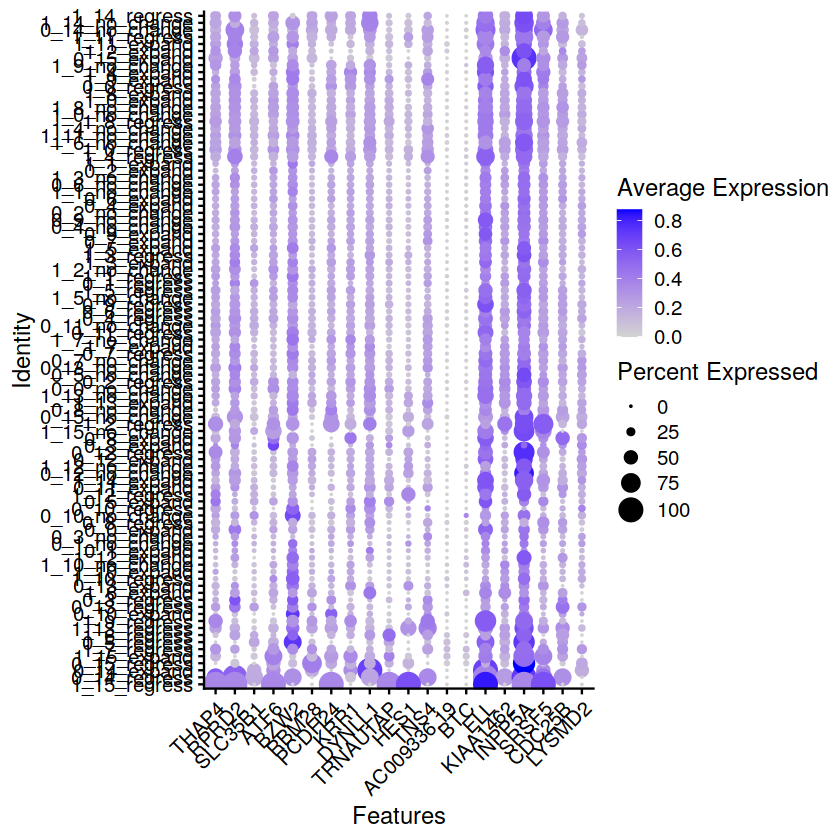

In [12]:
donors <- sort(unique(se.filt$donor))
all.pvals <- data.frame(matrix(nrow=dim(se.filt)[1],ncol=0),
                          row.names=row.names(se.filt))
all.names.sig <- c()
for (curr.donor in donors){
    print(paste0("donor ", curr.donor))
    for (curr.clust in clust.ids){
        print('clust')
        print(curr.clust)
        try({
            curr.se <- subset(se.filt, subset = (donor == curr.donor) & (seurat_clusters==curr.clust))

            changes <- unique(curr.se$change)
            if (length(changes)<2){
                print("Only one type of change for clone in this donor")
                print(changes)
                next
            }
            pairs <- combn(changes, 2)
            for (p in 1:ncol(pairs)){
                pair <- pairs[,p]
                print("pairs")
                print(pair)
                ident.1 = paste(curr.donor, curr.clust, pair[[1]] ,sep="_")
                ident.2 = paste(curr.donor, curr.clust, pair[[2]] ,sep="_")

                curr.name <- paste(ident.1, "vs", ident.2, "donor", curr.donor, "cluster", curr.clust, sep="_")
                #curr.dir <- paste0("donor", "_", curr.d)
                #curr.outdir <- file.path(donor.outdir, curr.dir)
                curr.outdir <- donor.outdir
                #dir.create(curr.outdir)

                ## Run DE
                curr.sig <- find.markers.and.plot(curr.se, ident.1, ident.2, curr.outdir, 
                                                  curr.name=curr.name, assay="RNA", logfcthresh=logfcthresh,
                                                  min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
                #curr.sig <- run.de(p)

                # Add DE to global results
                names.sig <- rownames(curr.sig)
                all.names.sig <- c(all.names.sig, head(names.sig, top_de))
                all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH
            }
        })
    }
   
}

### a) top 3 significant results from each comparison
if (length(all.names.sig)>0){
    all.names.sig <- unique(all.names.sig)
    de.plots(se.filt, all.names.sig, donor.outdir, curr.name="allDonors.allClusters", max.size=15)

    dot <- DotPlot(se.filt, scale=FALSE,
                   features = head(all.names.sig,20), 
                   cluster.idents=T) + RotatedAxis()
    dot
    ggsave(file.path(donor.outdir, "allDonors.allClusters.top3de.png"))
    ggsave(file.path(donor.outdir, "allDonors.allClusters.top3de.pdf"))
    }


## b) averaged top p-values (only average ones that were DE)
try({
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(donor.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(donor.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot
    
})

## All donors

[1] "clust"
[1] "0"
[1] "pair"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 600 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
HES1   5.684437e-09  0.1360977 0.261 0.079 0.0001112729 1.443847e-06
TNS4   2.582586e-07  0.1531943 0.403 0.190 0.0050554113 3.279884e-05
NPHP3  3.841336e-06  0.1376940 0.397 0.207 0.0751941591 2.862311e-04
TIGD7  4.507577e-06  0.1146624 0.220 0.082 0.0882358162 2.862311e-04
SART1  6.906403e-06  0.1124931 0.241 0.098 0.1351928469 2.980397e-04
TSEN54 7.569778e-06  0.1057618 0.336 0.164 0.1481784086 2.980397e-04
[1] "dim response"
[1] 254   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1693 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
ZFYVE1 2.940231e-05  0.1047936 0.349  0.23 0.5755502   0.00114669
[1] "dim response"
[1] 39  6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "expand"    "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1703 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                      p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
HES1           1.604766e-06 -0.1055217 0.079 0.194 0.03141329 8.184306e-05
NPHP3          3.814486e-05 -0.1143273 0.207 0.336 0.74668558 9.726939e-04
ARHGEF12       6.941920e-05  0.1164970 0.187 0.110 1.00000000 1.180126e-03
ANKRD12        2.891411e-04 -0.1482339 0.456 0.568 1.00000000 3.686549e-03
INTS6L         4.060072e-04 -0.1127478 0.357 0.475 1.00000000 4.141274e-03
EEF1AKMT4-ECE2 6.601838e-04 -0.1001085 0.230 0.339 1.00000000 4.997736e-03
[1] "dim response"
[1] 51  6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "clust"
[1] "1"
[1] "pair"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1382 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 546   6
[1] "pair"
[1] "no_change" "regress"  
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1304 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
EXOC3L1  8.910445e-07 -0.1037218 0.042 0.125 0.01744220 0.0004239713
HIST1H3J 1.547341e-06 -0.1764127 0.178 0.317 0.03028919 0.0004239713

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "expand"  "regress"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 558 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
PRPF8  4.610042e-07 -0.2296526 0.097 0.258 0.009024157 0.0004902999
INPP5B 8.077429e-07 -0.1987669 0.088 0.246 0.015811567 0.0004902999
TTF2   3.546618e-06 -0.2824055 0.236 0.442 0.069425039 0.0012765893
RPL18A 4.206225e-06 -0.1758457 0.097 0.246 0.082336857 0.0012765893
APBB1  2.163189e-05 -0.2615362 0.182 0.346 0.423444227 0.0045127255
RPL6   2.230342e-05 -0.1689385 0.053 0.162 0.436589467 0.0045127255
[1] "dim response"
[1] 1214    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "clust"
[1] "2"
[1] "pair"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1404 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
KIAA1462 5.602754e-09  0.1588210 0.389 0.221 0.0001096739 6.723305e-07
BZW2     7.561670e-07  0.1129803 0.376 0.233 0.0148019697 3.098470e-05
ATF6     7.746176e-07  0.1328855 0.335 0.201 0.0151631395 3.098470e-05
DYNLL1   1.307636e-06  0.1294963 0.338 0.204 0.0255969783 3.922909e-05
CDC25B   4.523533e-06  0.1017762 0.276 0.162 0.0885481515 1.085648e-04
SRSF5    1.245367e-05  0.1175541 0.363 0.234 0.2437805380 2.345225e-04
[1] "dim response"
[1] 120   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 898 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2    p_val_adj p_val_adj_BH
THAP4    2.623182e-08  0.1440930 0.269 0.114 0.0005134880 2.604784e-06
SRSF5    3.167960e-08  0.2007094 0.363 0.185 0.0006201282 2.604784e-06
INPP5A   3.609968e-08  0.2576117 0.565 0.351 0.0007066512 2.604784e-06
DYNLL1   3.929610e-08  0.1576871 0.338 0.166 0.0007692212 2.604784e-06
PCDH24   4.044695e-08  0.1289482 0.276 0.118 0.0007917490 2.604784e-06
KIAA1462 4.961614e-08  0.1360556 0.389 0.197 0.0009712360 2.662733e-06
[1] "dim response"
[1] 322   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1520 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 127   6
[1] "clust"
[1] "3"
[1] "pair"
[1] "no_change" "regress"  
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 523 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
             p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
DOC2B 2.345951e-06 -0.1231751 0.005 0.075  0.045922  0.004717708
[1] "dim response"
[1] 2011    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 553 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
GPR149 4.191006e-06 -0.1510646 0.018 0.109 0.08203895  0.007216913
[1] "dim response"
[1] 1722    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 190 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 3211    6
[1] "clust"
[1] "4"
[1] "pair"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1056 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
ARHGAP4 5.122612e-06  0.1646629 0.505 0.340 0.1002751 0.0006608169
UPF3B   2.926636e-05  0.1196370 0.312 0.188 0.5728889 0.0018876799
CFTR    

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 650 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                   p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
MBTPS1      1.314757e-07  0.1704103 0.336 0.146 0.002573637 6.534343e-05
SYS1-DBNDD2 3.496079e-07  0.1640865 0.390 0.186 0.006843575 7.107712e-05
KRBA1       4.290369e-07  0.1209757 0.247 0.093 0.008398398 7.107712e-05
PNPLA3      9.724362e-07  0.1085937 0.210 0.073 0.019035439 1.159608e-04
SYS1        1.166607e-06  0.1402055 0.353 0.166 0.022836335 1.159608e-04
FBXL12      2.452933e-06  0.1326071 0.475 0.254 0.048016171 1.864248e-04
[1] "dim response"
[1] 497   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1116 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
PTBP2    2.335413e-05  0.1100162 0.269 0.144 0.4571571  0.003478054
LRIG2    4.469534e-05  0.1057763 0.339 0.203 0.8749114  0.003478054
KMT2A    5.835527e-05  0.1545590 0.342 0.214 1.0000000  0.003478054
DNAJC7   7.600452e-05  0.1116078 0.197 0.101 1.0000000  0.003478054
RNF139   9.586651e-05  0.1094487 0.463 0.310 1.0000000  0.003478054
TNFRSF1B 9.616739e-05  0.1740226 0.406 0.279 1.0000000  0.003478054
[1] "dim response"
[1] 217   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "clust"
[1] "5"
[1] "pair"
[1] "no_change" "regress"  
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1056 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
SLAIN1  2.784748e-05 -0.2468695 0.236 0.383 0.5451144  0.006132732
LIN52   3.369400e-05 -0.2229371 0.417 0.583 0.6595601  0.006132732
ATP8B2  4.577642e-05 -0.2027871 0.263 0.422 0.8960733  0.006132732
ALDH6A1 4.611077e-05 -0.2142273 0.401 0.578 0.9026183  0.006132732
PDGFB   8.685432e-05 -0.1104833 0.070 0.161 1.0000000  0.009241299
ANKRD9  1.145907e-04 -0.1413839 0.062 0.144 1.0000000  0.009826438
[1] "dim response"
[1] 532   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1083 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 487   6
[1] "pair"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 387 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
             p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
NHP2  5.758218e-06  0.1925007 0.289 0.101 0.1127171  0.006771664
KCTD6 1.640068e-05  0.1396135 0.217 0.063 0.3210432  0.009643598
[1] "dim response"
[1] 1176    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "clust"
[1] "6"
[1] "pair"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 574 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
ATP5E    1.192979e-06  0.1793529 0.327 0.138 0.02335257 0.0004779670
KIAA0513 1.367574e-06  0.1883916 0.379 0.175 0.02677026 0.0004779670
TMEM161A 4.258545e-06  0.1106571 0.176 0.049 0.08336102 0.0009550526
C19orf73 5.465251e-06  0.1943977 0.248 0.101 0.10698228 0.0009550526
PPFIA3   1.930279e-05  0.2296768 0.389 0.220 0.37785218 0.0023568875
DDX5     2.103707e-05  0.1756678 0.474 0.280 0.41180069 0.0023568875
[1] "dim response"
[1] 699   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 982 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                    p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
IL4I1        1.296946e-05  0.1141998 0.288 0.161 0.2538772  0.001672999
MRPL24       1.322529e-05  0.1495822 0.245 0.133 0.2588851  0.001672999
NUP62        3.259055e-05  0.1056297 0.225 0.120 0.6379600  0.002010351
CTC-326K19.6 3.588203e-05  0.1107240 0.245 0.135 0.7023908  0.002010351
POLR3H       3.973026e-05  0.1158530 0.229 0.124 0.7777199  0.002010351
SYP          9.993809e-05  0.1356816 0.369 0.243 1.0000000  0.004087730
[1] "dim response"
[1] 253   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "expand"    "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 944 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 421   6
[1] "clust"
[1] "7"
[1] "pair"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 376 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 1276    6
[1] "pair"
[1] "regress"   "no_change"
[1] "se filt before"


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "expand"    "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 761 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 634   6
[1] "clust"
[1] "8"
[1] "pair"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 387 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
               p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
FDFT1   4.462848e-07  0.2855082 0.515 0.244 0.008736025 0.0003132919
FAM105A 4.026829e-06  0.2348923 0.435 0.189 0.078825186 0.0014134171
[1] "

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 1081 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                   p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
PYCRL       6.570061e-06  0.1148935 0.385 0.234 0.1286090 0.0003679234
ZNF37A      1.896980e-05  0.1083963 0.354 0.219 0.3713338 0.0005311544
PALM2-AKAP2 6.586411e-05  0.1144530 0.450 0.297 1.0000000 0.0011841087
CLDN12      8.457920e-05  0.1036481 0.412 0.263 1.0000000 0.0011841087
UBE4B       1.582696e-04  0.1163936 0.400 0.272 1.0000000 0.0015727336
ITPKB       1.897275e-04  0.1576912 0.904 0.853 1.0000000 0.0015727336
[1] "dim response"
[1] 56  6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "expand"    "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 948 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
             p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
FDFT1 1.128343e-06 -0.2604093 0.244 0.469 0.02208732 0.0005438614
[1] "dim response"
[1] 482   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "clust"
[1] "9"
[1] "pair"
[1] "regress"   "no_change"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 749 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
DHX37  1.735065e-06  0.1313337 0.200 0.073 0.03396389  0.000886618
NDEL1  3.613295e-06  0.1626587 0.368 0.191 0.07073026  0.000923197
NLE1   2.664571e-05  0.1079919 0.147 0.054 0.52158973  0.004538652
TMEM52 8.046755e-05  0.1003936 0.337 0.186 1.00000000  0.005601853
ANP32E 8.253606e-05  0.1607819 0.453 0.283 1.00000000  0.005601853
ITSN1  9.258599e-05  0.2030581 0.632 0.440 1.00000000  0.005601853
[1] "dim response"
[1] 511   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 439 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
                     p_val avg_log2FC pct.1 pct.2   p_val_adj p_val_adj_BH
THEMIS2       8.811826e-08  0.1395470 0.163 0.020 0.001724915 0.0001019528
CTD-2583A14.9 1.454860e-06  0.1382857 0.274 0.088 0.028478877 0.0005010705
IMPAD1        1.758892e-06  0.1524720 0.216 0.060 0.034430308 0.0005010705
VPS52         1.978613e-06  0.1304280 0.189 0.044 0.038731356 0.0005010705
ATP8B2        2.319629e-06  0.2309398 0.379 0.165 0.045406745 0.0005010705
DIS3          2.598464e-06  0.2078044 0.411 0.189 0.050864938 0.0005010705
[1] "dim response"
[1] 1157    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 808 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
SKP2   1.161531e-05  0.1727885 0.277 0.129 0.2273696  0.006516187
LMBRD2 3.561997e-05  0.1380119 0.275 0.133 0.6972609  0.008083405
CACNB3 5.754376e-05  0.1204185 0.114 0.028 1.0000000  0.008083405
KRI1   6.604659e-05  0.1550859 0.267 0.137 1.0000000  0.008083405
MAEA   7.204461e-05  0.2027157 0.435 0.281 1.0000000  0.008083405
SSR1   9.374598e-05  0.1455359 0.213 0.096 1.0000000  0.008363521
[1] "dim response"
[1] 561   6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "clust"
[1] "10"
[1] "pair"
[1] "no_change" "regress"  
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 412 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
             p_val avg_log2FC pct.1 pct.2  p_val_adj p_val_adj_BH
BSPRY 1.705182e-06 -0.1831779 0.017  0.14 0.03337893  0.005746462
[1] "dim response"
[1] 3370    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 463 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 2275    6
[1] "pair"
[1] "regress" "expand" 
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 165 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 4246    6
[1] "clust"
[1] "11"
[1] "pair"
[1] "no_change" "expand"   
[1] "se filt befor

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "expand"  "regress"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 159 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
              p_val avg_log2FC pct.1 pct.2 p_val_adj p_val_adj_BH
DFNB31 1.580961e-06 -0.3969014 0.125 0.465 0.0309473  0.004161088
[1] "dim response"
[1] 2632    6


Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "clust"
[1] "12"
[1] "pair"
[1] "no_change" "regress"  
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 173 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 4193    6
[1] "pair"
[1] "no_change" "expand"   
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 184 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 3882    6
[1] "pair"
[1] "regress" "expand" 
[1] "se filt befor

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



[1] "gally"
[1] "p_val"        "avg_log2FC"   "pct.1"        "pct.2"        "p_val_adj"   
[6] "p_val_adj_BH"


Saving 6.67 x 6.67 in image



[1] "pair"
[1] "expand"  "regress"
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 27 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 7105    6
[1] "clust"
[1] "15"
[1] "pair"
[1] "no_change" "regress"  
[1] "se filt before"
[1] "se filt"
An object of class Seurat 
97805 features across 31 samples within 2 assays 
Active assay: RNA (19575 features, 0 variable features)
 1 other assay present: ATAC
 2 dimensional reductions calculated: integrated_lsi, umap
[1] "curr sig"
[1] p_val        avg_log2FC   pct.1        pct.2        p_val_adj   
[6] p_val_adj_BH
<0 rows> (or 0-length row.names)
[1] "dim response"
[1] 7376    6
[1] "pair"
[1] "no_change" "expand"   
[1] "se filt before"

The automatically generated colors map from the 1^st and 99^th of the
values in the matrix. There are outliers in the matrix whose patterns
might be hidden by this color mapping. You can manually set the color
to `col` argument.

Use `suppressMessages()` to turn off this message.

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



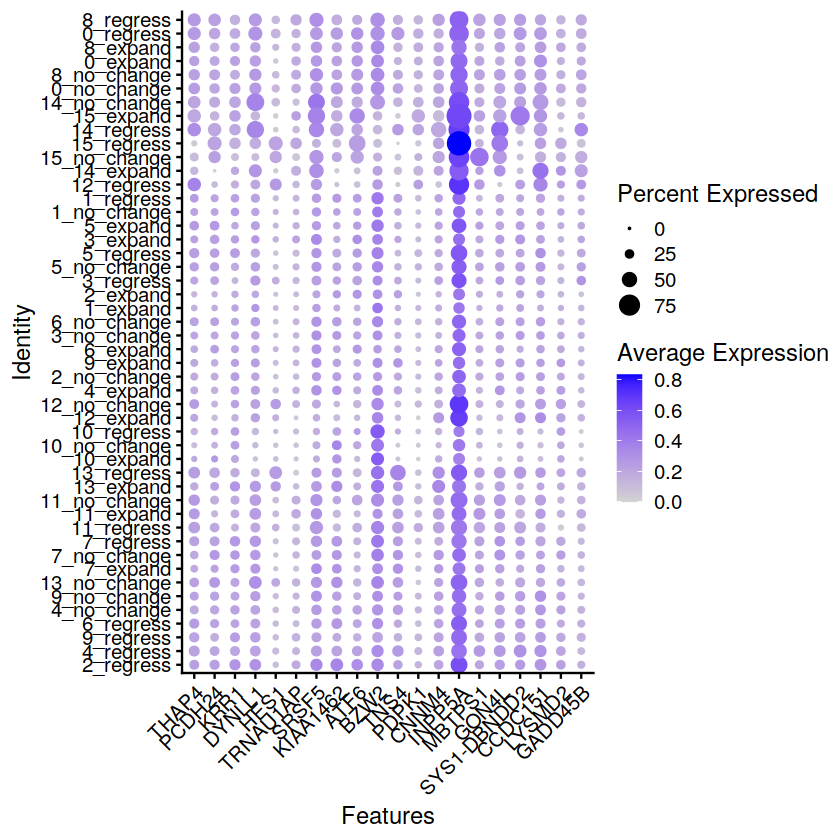

In [13]:
curr.outdir <- all.donor.outdir

Idents(se.filt) <- as.factor(apply(se.filt[[]][ , c("seurat_clusters", "change") ] , 1 , paste , collapse = "_" ))

all.pvals <- data.frame(matrix(nrow=dim(se.filt)[1],ncol=0),
                          row.names=row.names(se.filt))
all.names.sig <- c()

for (curr.clust in clust.ids){
    print('clust')
    print(curr.clust)
    try({
        curr.se <- subset(se.filt, subset = (seurat_clusters==curr.clust))

        changes <- unique(curr.se$change)
        if (length(changes)<2){
            print("Only one type of change for clone in this donor")
            print(changes)
            next
        }
        pairs <- combn(changes, 2)
        for (p in 1:ncol(pairs)){
            pair <- pairs[,p]
            print('pair')
            print(pair)
            ident.1 = paste(curr.clust, pair[[1]] ,sep="_")
            ident.2 = paste(curr.clust, pair[[2]] ,sep="_")

            curr.name <- paste(ident.1, "vs", ident.2, "cluster", curr.clust, sep="_")
            #curr.dir <- paste0("donor", "_", curr.d)
            #curr.outdir <- file.path(donor.outdir, curr.dir)
            
            #dir.create(curr.outdir)

            ## Run DE
            curr.sig <- find.markers.and.plot(curr.se, ident.1, ident.2, curr.outdir, 
                                              curr.name=curr.name, assay="RNA", logfcthresh=logfcthresh,
                                              min.pct=minPct, p.thresh=p_thresh, mean.fxn=NULL, fc.name=NULL)
            #curr.sig <- run.de(p)
            # Add DE to global results
            names.sig <- rownames(curr.sig)
            all.names.sig <- c(all.names.sig, head(names.sig, top_de))
            all.pvals[names.sig,curr.name] <- curr.sig$p_val_adj_BH
        }
    })
}


### a) top 3 significant results from each comparison
if (length(all.names.sig)>0){
    all.names.sig <- unique(all.names.sig)
    de.plots(se.filt, all.names.sig, curr.outdir, curr.name="allDonors.allClusters", max.size=15)

    dot <- DotPlot(se.filt, scale=FALSE,
                   features = head(all.names.sig,20), 
                   cluster.idents=T) + RotatedAxis()
    dot
    ggsave(file.path(curr.outdir, "allDonors.allClusters.top3de.png"))
    ggsave(file.path(curr.outdir, "allDonors.allClusters.top3de.pdf"))
    }


## b) averaged top p-values (only average ones that were DE)
try({
sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=T,
               features = names(head(sig.all.ordered,20)), 
               cluster.idents=T) + RotatedAxis()
dot
ggsave(file.path(curr.outdir, "allDonors.allClusters.pvalsOrdered.png"))
ggsave(file.path(curr.outdir, "allDonors.allClusters.pvalsOrdered.pdf"))
#de.plots(se, names(sig.all.ordered), outdir, curr.name="allDonors.allClusters.pvalsOrdered", max.size=20)

sig.all.ordered <- sort(rowMeans(-log10(all.pvals),na.rm=T), decreasing=T)
dot <- DotPlot(se.filt, scale=F,
               features = head(names(sig.all.ordered),20), 
               cluster.idents=T) + RotatedAxis()
dot
    
})

In [14]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.4 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] future_1.23.0             RColorBrewer_1.1-2       
 [3] metap_1.1                 cowplot_1.1.1            
 [5] magrittr_2.0.2            data.table_1.14.2        
 [7] patchwork_1.1.1           ggplot2_3.3.5            
 [9] EnsDb.Hsapiens.v75_2.99.0 ensembldb_2.18.1         
[11] 

In [15]:
outdir

[1] "/data/Mito_Trace/output/pipeline/TcellDupi_may17_2021/MTblacklist/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_3/concat/gff_hg38_1_2/clones_change/filt_fisher__shuffle_False__padj_True__pthresh_0.01_minC_1__bothMinC__0/de/btwnChange_inClust/minPct_0.01__logfc0.1_pthresh_0.01"